In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
#%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [3]:
import numpyam as npm # some math functions 
from process import one_hot_encoder, get_normalized_data

In [4]:
X, Y = get_normalized_data('train') #training data contains labels Y
X_test_file, _ = get_normalized_data('test') #test data has no labels 

#### Processing the Data

In [5]:
# The get_normalized_data function shuffles the data already. 
# Take a small validation portion 
X_valid = X[:1000]
Y_valid = Y[:1000]
X_train = X[1000:]
Y_train = Y[1000:]

T_train, _ = one_hot_encoder(Y_train)
T_valid, _ = one_hot_encoder(Y_valid)

#### Parameters

In [6]:
eta = 0.00004 # learning rate
reg = 0.01 #regularization parameter
mu = 0.9 #momentum parameter

N, D = X_train.shape # number of data points, data dimension

M = 30 # number of neurons
_, K = T_train.shape # number of classes

#### Network architecture

In [7]:
#initial values
W1_0 = np.random.randn(D,M) / np.sqrt(D) 
b1_0 = np.zeros(M)
W2_0 = np.random.randn(M,K) / np.sqrt(M)
b2_0 = np.zeros(K)

thX = T.matrix('X')
thT = T.matrix('T')
# weights
W1 = theano.shared(W1_0, 'W1')
b1 = theano.shared(b1_0, 'b1')
W2 = theano.shared(W2_0, 'W2')
b2 = theano.shared(b2_0, 'b2')

# velocities
vW1 = theano.shared(W1_0*0, 'vW1')
vb1 = theano.shared(b1_0, 'vb1')
vW2 = theano.shared(W2_0*0, 'vW2')
vb2 = theano.shared(b2_0, 'vb2')

thH = T.nnet.relu(thX.dot(W1) + b1)
thYhat = T.nnet.softmax(thH.dot(W2) + b2)

#### Entropy and prediction

In [8]:
cost = -(thT * T.log(thYhat)).sum() + reg*( (W1*W1).sum() + (b1*b1).sum() + (W2*W2).sum() + (b2*b2).sum() )

prediction = T.argmax(thYhat, axis=1)

#### Gradient descent

In [9]:
'''
# no momentum
W1_update = W1 - eta * T.grad(cost, W1) 
b1_update = b1 - eta * T.grad(cost, b1)
W2_update = W2 - eta * T.grad(cost, W2)
b2_update = b2 - eta * T.grad(cost, b2)
# end 
'''

# Nesterov momentum
gW1 = - eta * T.grad(cost, W1) 
gb1 = - eta * T.grad(cost, b1)
gW2 = - eta * T.grad(cost, W2)
gb2 = - eta * T.grad(cost, b2)

vW1 = mu*vW1 + gW1
vb1 = mu*vb1 + gb1
vW2 = mu*vW2 + gW2
vb2 = mu*vb2 + gb2

W1_update = W1 + mu*vW1 + gW1 
b1_update = b1 + mu*vb1 + gb1
W2_update = W2 + mu*vW2 + gW2
b2_update = b2 + mu*vb2 + gb2
# end

#### Training and functions

In [10]:
updates = [(W1, W1_update), (b1, b1_update), (W2, W2_update), (b2, b2_update)]

train = theano.function(inputs=[thX,thT], updates = updates)

get_prediction = theano.function(inputs=[thX,thT], outputs=[cost,prediction])

predict = theano.function(inputs=[thX], outputs=prediction)

#### Gradient descent loop

In [11]:
full_iter = 20 #number of iterations over the entire data
batch_size = 200
batch_num = N // batch_size

J_list = [] # list of cost function for all iterations
acc_list = [] # list of classification rates for all iterations
for i in range(full_iter):
    for j in range(batch_num):
        X_batch = X_train[j*batch_size: (j+1)*batch_size]
        T_batch = T_train[j*batch_size: (j+1)*batch_size]
        
        train(X_batch, T_batch)
        J, Y_pred = get_prediction(X_valid, T_valid)
        J_list.append(J)
        acc = npm.classification_rate(Y_pred, Y_valid)
        acc_list.append(acc)


#### Cost function

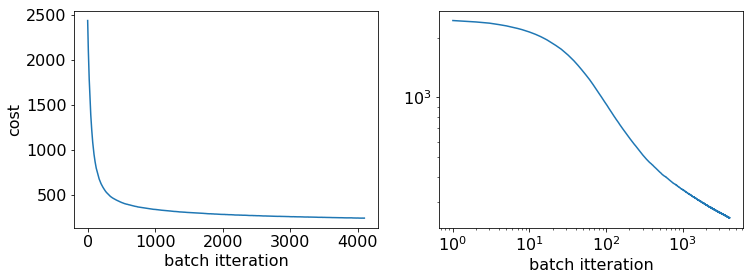

In [12]:
plt.figure(figsize=(12,4))

# linear
plt.subplot(121)
plt.plot(J_list)
plt.ylabel('cost')
plt.xlabel('batch itteration')

# log
plt.subplot(122)
plt.plot(range(1,len(J_list)+1), J_list)
plt.xlabel('batch itteration')
plt.xscale('log')
plt.yscale('log')

plt.show()

#### Prediction rate

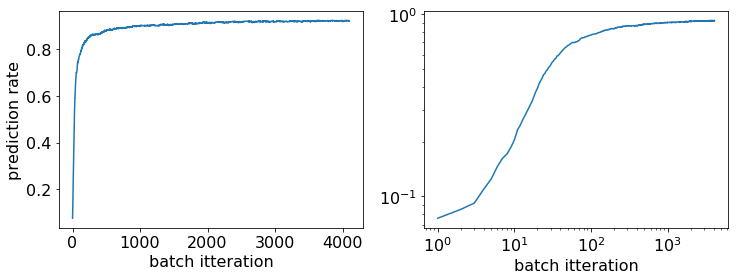

In [13]:
plt.figure(figsize=(12,4))

# linear
plt.subplot(121)
plt.plot(acc_list)
plt.ylabel('prediction rate')
plt.xlabel('batch itteration')

# log
plt.subplot(122)
plt.plot(range(1,len(acc_list)+1), acc_list)
plt.xlabel('batch itteration')
plt.xscale('log')
plt.yscale('log')

plt.show()

#### Predict image categories in 'test' file

In [14]:
Y_test_pred = predict(X_test_file)

#### Plot test examples

In [15]:
# picks a random data point from X and Y, and makes a subplot of it given 'row' number of rows and 'col' number of columns.
# 'index' = row*d + col is the cumulative position of the specific subplot in the plot. 

im_size = np.sqrt(D).astype(int) # im_size = 28 is size of the square images. D = 28*28 = 748

def plot_a_test(X, Y, row, col, index):
    N = len(X)
    n = np.random.randint(N)
    X_im = X[n,:].reshape(im_size,im_size)
    num = Y[n]
    plt.subplot(row, col, index)
    plt.imshow(X_im, cmap='Greys')
    #plt.title(str(num))
    plt.text(1,6,str(num))
    plt.xticks([])
    plt.yticks([])

##### The number on the upper left of each cell is the predicted value by the model. 

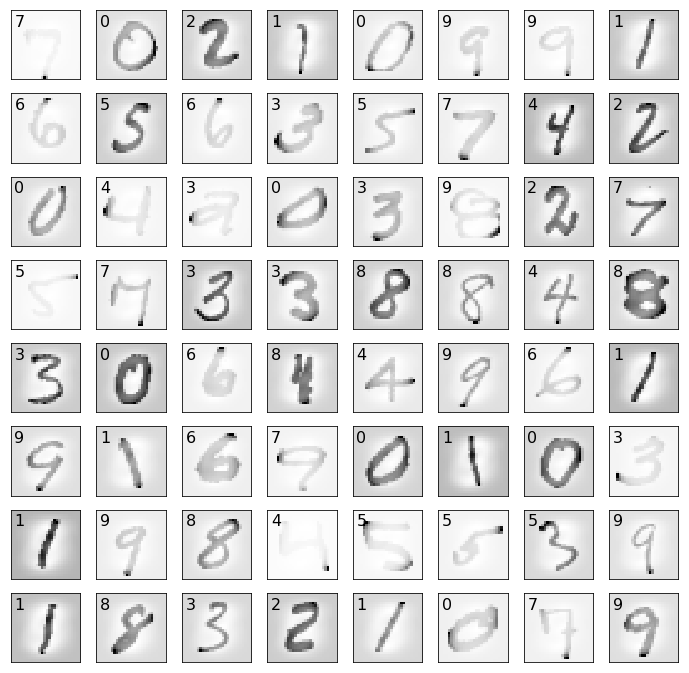

In [16]:
d = 8
plt.figure(figsize=(12,12))
for i in range(d):
    for j in range(1,d+1):
        plot_a_test(X_test_file, Y_test_pred, d, d, i*d+j)
plt.show()